In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [184]:
class SWIFTActiveEstimator(object):
    # initializer
    def __init__(self, desired_recall_level = .95):
        self._X = None
        self.last_judged_position = -1
    
    def set_data(self, X):
        self._X = X
        self._num_rel = len(self._X[self._X['Label'] == 1])
        self._num_nonrel = len(self._X[self._X['Label'] == 0])
        self._num_unjudged = len(self._X[self._X['Label'] == -1])
        
        # check data: report number of rows that are relevant/non-relevant/unjudged
        print ('Number of relevant:', self._num_rel)
        print ('Number of non-relevant:', self._num_nonrel)
        print ('Number of unjudged:', self._num_unjudged)
        
        # add an additional row: cumulative count of relevant docs
        cumulative_rel = []
        count = 0
        for i, row in self._X.iterrows():
            if row['Label'].item() == 1:
                count += 1
            cumulative_rel.append(count)
                
        self._X['CumulativeRel'] = cumulative_rel
    
    
    # Params:
    #       position: the position after which we estimate the number of remaining relevant 
    #       lookback: number of relevant documents to look back from the given position
    # Return:
    #     None: error
    #     non-negative integer: estimate
    
    def _pass_sanity_check(self, position, lookback):
        if position < 0 or position > len(self._X):
            print ('Error: The parameter position has to be an integer between 0 and {} (length of rank list).'.format(len(self._X)))
            return False
        if lookback < 1:
            print ('Error: The parameter lookback has to be an integer >= 1')
            return False
        
        # make sure that everything on or above position is either 1 or 0
        for i, row in self._X.iterrows():
            if i <= position and (row['Label'] != 0 and row['Label'] != 1):
                print ('Error: Row {}\'s label is not 0 or 1. It is before position {}.'.format(i, position))
                return False
            elif i > position:
                break
        return True
    
    def estimate_remaining_relevant(self, position, lookback):
        if not self._pass_sanity_check(position, lookback):
            return None
        
        # look back to the last relevant position
        
#         num_of_rel_found = 0
#         travel_length = 0
#         for i in range(position, -1, -1):
#             if self._X.iloc[[i]]['Label'].item() == 1:
#                 num_of_rel_found += 1
#             if num_of_rel_found == lookback:
#                 travel_length += 1
#                 break
#             travel_length += 1

        num_rel_at_position = self._X.iloc[[position]]['CumulativeRel'].item()
        if num_rel_at_position < lookback:
            num_of_rel_found = num_rel_at_position
            back_point = 0
        else:
            num_of_rel_found = lookback
            back_point = self._X['CumulativeRel'].searchsorted(num_rel_at_position - lookback)
        
        travel_length = position - back_point + 1
        
        # estimate instantaneous_precision, at the given position
        if travel_length > 0:
            instantaneous_precision = num_of_rel_found / travel_length
        elif travel_length == 0 and num_of_rel_found > 0:
            instantaneous_precision = 1.0
        else:
            instantaneous_precision = 0.0
        
#         print ('position:', position)
#         print ('travel_length:', travel_length)
#         print ('num_of_rel_found:', num_of_rel_found)
#         print ('instantaneous_precision:', instantaneous_precision)
        
        return np.ceil(instantaneous_precision * (len(self._X) - position))
    
    def estimate_recall(self, position, lookback):
        if not self._pass_sanity_check(position, lookback):
            return None
        
        # count number of relevant docs at position
        num_rel_at_position = self._X.iloc[[position]]['CumulativeRel'].item()
        if num_rel_at_position == 0:
            return 0.0
        
        num_remaining_relevant = self.estimate_remaining_relevant(position, lookback)
        return num_rel_at_position / (num_rel_at_position + num_remaining_relevant)
    
    def plot_true_and_estimated_recall_curves(self, lookback, total_rel, step_size):
        
        x_list = []
        true_recall_list = []
        esti_recall_list = []
        
        # iterate over all positions, collect points on the recall curves
        num_rel = 0
        for i, row in self._X.iterrows():
            if row['Label'].item() != 0 and row['Label'].item() != 1:
                break
            
            if row['Label'].item() == 1:
                num_rel += 1
            
            if i % step_size == 0:
                x_list.append( i + 1 )
                true_recall_list.append( num_rel / total_rel )
                esti_recall_list.append( self.estimate_recall(i, lookback) )
                
                sys.stdout.write('Plotting: Row {}\r'.format(i))
        
        plt.title('True and estimated recall curves')
        plt.plot(x_list, true_recall_list, 'r', label='true recall')
        plt.plot(x_list, esti_recall_list, 'b', label='estimated recall (lookback = {})'.format(lookback))
        plt.legend()
        plt.xlabel('Position in rank list')
        plt.ylabel('Recall')
        plt.show()
        
        return x_list, true_recall_list, esti_recall_list
    

# test on synthetic simple ranked list

Number of relevant: 2
Number of non-relevant: 3
Number of unjudged: 1


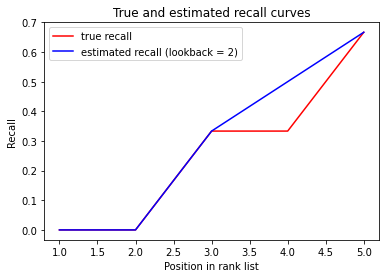

([1, 2, 3, 4, 5],
 [0.0, 0.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666],
 [0.0, 0.0, 0.3333333333333333, 0.5, 0.6666666666666666])

In [185]:
d = {'Label': [0, 0, 1, 0, 1, -1]}
lookback = 2
position = 0
total_rel = 3
step_size = 1
df = pd.DataFrame(data = d)
est = SWIFTActiveEstimator()
est.set_data(df)
# print('estimate_remaining_relevant', est.estimate_remaining_relevant(position, lookback))
# print('estimate_recall', est.estimate_recall(position, lookback))
est.plot_true_and_estimated_recall_curves(lookback, total_rel, step_size)

# test on ozone 2020 S set ranked by simple text ranker

In [186]:
rank_data_filepath = '../dat/text_based_simple_ranker_score.csv'

In [187]:
# load a dataframe, simulate the scenario where the lower part of the ranked list is "unjudged" (label = -1) 
rank_dataframe = pd.read_csv(rank_data_filepath)
total_rel = 0
for i, row in rank_dataframe.iterrows():
    if i >= 100000:
        rank_dataframe.at[i,'Label'] = -1
    if row['Label'].item() == 1:
        total_rel += 1

In [188]:
total_rel

1153

Number of relevant: 1131
Number of non-relevant: 98869
Number of unjudged: 71376


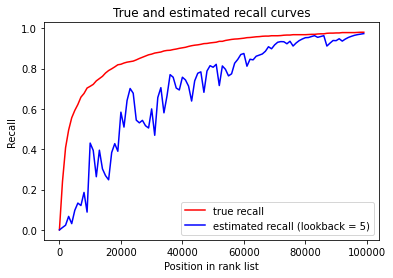

([1,
  1001,
  2001,
  3001,
  4001,
  5001,
  6001,
  7001,
  8001,
  9001,
  10001,
  11001,
  12001,
  13001,
  14001,
  15001,
  16001,
  17001,
  18001,
  19001,
  20001,
  21001,
  22001,
  23001,
  24001,
  25001,
  26001,
  27001,
  28001,
  29001,
  30001,
  31001,
  32001,
  33001,
  34001,
  35001,
  36001,
  37001,
  38001,
  39001,
  40001,
  41001,
  42001,
  43001,
  44001,
  45001,
  46001,
  47001,
  48001,
  49001,
  50001,
  51001,
  52001,
  53001,
  54001,
  55001,
  56001,
  57001,
  58001,
  59001,
  60001,
  61001,
  62001,
  63001,
  64001,
  65001,
  66001,
  67001,
  68001,
  69001,
  70001,
  71001,
  72001,
  73001,
  74001,
  75001,
  76001,
  77001,
  78001,
  79001,
  80001,
  81001,
  82001,
  83001,
  84001,
  85001,
  86001,
  87001,
  88001,
  89001,
  90001,
  91001,
  92001,
  93001,
  94001,
  95001,
  96001,
  97001,
  98001,
  99001],
 [0.0,
  0.24024284475281873,
  0.40763226366001737,
  0.49522983521248914,
  0.5559410234171726,
  0.5923677363

In [189]:
estimator = SWIFTActiveEstimator()
lookback = 5
position = 5000
total_rel = 1153
step_size = 1000
estimator.set_data(rank_dataframe)
estimator.estimate_remaining_relevant(position, lookback)
estimator.estimate_recall(position, lookback)
estimator.plot_true_and_estimated_recall_curves(lookback, total_rel, step_size)